## Umgebung vorbereiten

In [ ]:
!pwd

In [ ]:
!git clone https://github.com/edadunashvili/ThePrax.git

In [ ]:
cd ThePrax

In [ ]:
!pwd

In [ ]:
!pip install pyprind

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Korpus von Trainingsdaten erstellen

 !!! Den gesuchten Typ bestimmen !!!

In [1]:
typNum='301'
episode_string_train = "a301_string_train.csv"
episode_roh_train = "a301_roh_train.csv"

Vorhandener gleichnamiger Korpus wird gelöscht 

In [2]:
import os
if os.path.exists(episode_string_train):
    os.remove(episode_string_train)
else:
    print("Diese Datei existiert nicht")

Diese Datei existiert nicht


Im Ordner "Trainingsdaten" nach den entsprechenden Textdateien suchen und in einer rohe Datei zusammentragen

In [3]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_train,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_train, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []


for file in glob.glob("Trainingsdaten/*.txt"):
    
    if typNum in file:
        with open(file, 'r', encoding='utf-8') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [4]:
fin = open(episode_roh_train,'r', encoding ='utf-8')
fout = open(episode_string_train, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Liste von einmaligen Episoden aus der CSV Datei zeigen

In [5]:
import pandas as pd
df = pd.read_csv(episode_string_train, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({"'0'": 23, "'e301_g_von_der_begegnung_mit_dem_an_oder_vb_bis_zum_betreten_des_wohngebiets_des_an'": 12, "'e301_e_vom_beginn_der_wanderung_bis_zur_begegnung_mit_an_oder_vb'": 12, "'e301_o_von_der_rueckkehr_an_die_oberflaeche_bis_zur_hochzeit_mit_dem_ob_und_der_bestrafung_der_fh'": 10, "'e301_k_das_befreite_ob_wird_zu_fh_geschickt_und_held_wird_zurueckgelassen'": 10, "'e301_i_vom_betreten_der_unterwelt_bis_zur_befreiung_des_ob'": 10, "'e301_m_rueckkehr_des_helden_in_die_aussenwelt'": 8, "'e554_a_'": 5, "'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'": 4, "'e300_e_vorfeld_des_kampfes_bis_zum_sieg'": 4, "'e300_o_auftritt_des_helden_vor_dem_koenig_bis_zum_ende_der_geschichte'": 4, "'e328_a_'": 4, "'e302_a_'": 3, "'e300_i_rueckkehr_der_koenigstochter_und_die_suche_nach_dem_held retter'": 3, "'e516_a_'": 2, "'e513a_a_'": 2, "'e300_g_nach_dem_sieg_bis_zur_trennung_des_befreiers_und_der_befreiten'": 2, "'e300_k_misshandlung_des_falschen_helden_bis_zur_hochzeitstag'": 2, "'e5

## Modell erstellen und trainieren

Bibliotheken laden

In [6]:
import keras
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pyprind
import pandas as pd
import random
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from keras import backend as K
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers
from keras.preprocessing import sequence

Using TensorFlow backend.


!!! Variable anpassen !!!

In [7]:
ziel_episode = 'e301_g_von_der_begegnung_mit_dem_an_oder_vb_bis_zum_betreten_des_wohngebiets_des_an'
mini_frequenz = 2
k_fach = 5
layD = 96
episode_string_train = 'a301_string_train.csv' 
episode_binar_train = 'a301_binar_train.csv'

Aufbereitung der Trainingsdaten.
Rohdaten laden und und den Episodenbestand betrachten

In [8]:
fin = open(episode_string_train,'r', encoding='utf-8') 
fout = open(episode_binar_train, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))  
fin.close()
fout.close()

Die in der CSV Datei etikettierte Episoden auflisten

In [9]:
df = pd.read_csv(episode_binar_train, encoding='utf-8')
indexliste=Counter(df.index_string)
#print(*indexliste, sep='\n')

Die gesuchte Episode etikettieren und den Rohdaten in Trainingsdaten umwandeln

In [10]:
for i,e in enumerate(df.index_string):
    if e == ziel_episode:
        df.index_binar[i]='1'
    else: 
        df.index_binar[i]='0'

In [11]:
df.to_csv(episode_binar_train, encoding='utf-8', index=False)

Trainngsdaten aufbereiten. Das Vorkommen jedes Wortes zählen

In [12]:
nltk.download('stopwords')
w = stopwords.words('german')
counts = Counter()
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Vorkommen der Wörter zählen')
for i, episode in enumerate(df['episode']): 
        pbar.update()
        counts.update(episode.split())
new_counts = {}
for k, v in counts.items():
    if v > mini_frequenz and k not in w:
        new_counts[k] = v
counts = Counter(new_counts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elguj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
Vorkommen der Wörter zählen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [13]:
#print(counts)

Zuordnung erzeugen und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [14]:
word_counts = sorted(counts, key=counts.get, reverse=True)
word_to_int = {word: ii for ii, word in enumerate(word_counts,0)}
mapped_episoden = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()
mapped_episoden = [list(filter(None, el)) for el in mapped_episoden]

Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [15]:
#print(word_to_int)

In [16]:
#print(mapped_episoden[0])

Traiingsndaten und Trainingslabels bestimmen

In [17]:
train_data = mapped_episoden[0:] 
train_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ",
      "train_data =", len (train_data))

sequences = 1425   train_data = 133


Trainingsdaten und -Labels vektorisieren

In [18]:
sequences_laenge=max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data) 
y_train = np.asarray(train_labels).astype('float32')

In [19]:
#for i, element in enumerate(x_train[0]):
    #print(i,'-', element)

Neuronales Netz erzeugen

In [20]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(layD, activation='tanh',
                           input_shape=(sequences_laenge+1,)))
    #model.add(layers.Dense(layD, activation='relu'))
    model.add(layers.Dense(layD, activation='tanh')) 
    model.add(layers.Dense((1), activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['binary_accuracy'])
    return model

Neuronales Netz trainieren

In [21]:
k = k_fach
num_val_samples = len(x_train) // k 
num_epochs = 4
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_x_train, partial_y_train,
              epochs=num_epochs, batch_size = 8, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_binary_accuracy = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_binary_accuracy)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [22]:
all_scores

[0.9615384340286255,
 0.9230769276618958,
 0.9230769276618958,
 0.8846153616905212,
 0.8846153616905212]

In [23]:
np.mean(all_scores)

0.9153846025466919

In [24]:
num_epochs = 8
all_binary_accuracy_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size = 8, verbose=0)
    binary_accuracy_history = history.history['val_binary_accuracy']
    all_binary_accuracy_histories.append(binary_accuracy_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [25]:
average_binary_accuracy_history = [
    np.mean([x[i] for x in all_binary_accuracy_histories]) for i in range(num_epochs)]
for i, element in enumerate(average_binary_accuracy_history):
    print(i,'-', element)

0 - 0.9076923076923077
1 - 0.9153846153846154
2 - 0.923076923076923
3 - 0.9153846153846154
4 - 0.9153846153846154
5 - 0.9153846153846154
6 - 0.9153846153846154
7 - 0.9076923076923077


## Messdaten erstellen

!!! Den gesuchten Typ bestimmen !!!

In [58]:
typNum =''
episode_string_mess = "gesamt_string_mess.csv"
episode_roh_mess = "gesamt_roh_mess.csv"
episode_binar_mess = "gesamt_binar_mess.csv"

Alte Datei mit gleichem Namen löschen

In [59]:
import os
if os.path.exists(episode_string_mess):
    os.remove(episode_string_mess)
else:
    print("Diese Datei existiert nicht")

Nach den entsprechenden Textdateien im Ordnet suchen und in einer rohe Datei zusammentragen

In [60]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_mess,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_mess, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []

for file in glob.glob("Messdaten/*.txt"):
    if typNum in file:
        with open(file, 'r', encoding='utf-8') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [61]:
fin = open(episode_roh_mess,'r', encoding ='utf-8')
fout = open(episode_string_mess, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Die in der CSV Datei etikettierte Episoden auflisten

In [62]:
import pandas as pd
df = pd.read_csv(episode_string_mess, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(*indexliste, sep='\n')

'0'


Messdaten laden und aufbereiten

In [63]:
fin = open(episode_string_mess,'r', encoding='utf-8') 
fout = open(episode_binar_mess, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))
                                 
fin.close()
fout.close()

In [64]:
df = pd.read_csv(episode_binar_mess, encoding='utf-8')
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({0: 234})


In [65]:
for i,e in enumerate(df.index_string):
    if e:
        df.index_binar[i]='0'
    else: 
        df.index_binar[i]='0'

C:\Users\elguj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [66]:
df.to_csv(episode_binar_mess, encoding='utf-8', index=False)

Vorhandene Zuordnung laden und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [67]:
mapped_episoden_2 = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden_2.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()

mapped_episoden_2 = [list(filter(None, el)) for el in mapped_episoden_2]


Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [68]:
#mapped_episoden_2 = []
#pbar = pyprind.ProgBar(len(df['episode']),
                       #title='Episoden Zahlen zuordnen')
#for  episode in df['episode']:
    #if type(episode) == str:
        #mapped_episoden_2.append([word_to_int.get(word) for word in episode.split()])
        #pbar.update()
#mapped_episoden_2 = [list(filter(None, el)) for el in mapped_episoden_2]

raiingsndaten und Trainingslabels bestimmen

In [69]:
mess_data = mapped_episoden_2[0:] 
mess_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ", 
      "mess_data =", len (mess_data))

sequences = 1425   mess_data = 234


Messdaten vektorisieren

In [70]:
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_mess = vectorize_sequences(mess_data)
y_mess = np.asarray(mess_labels).astype('float32')

## Messdaten analysieren

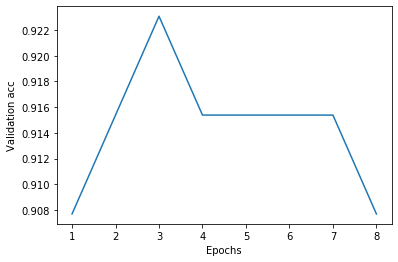

In [71]:
plt.plot(range(1, len(average_binary_accuracy_history) + 1), average_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

!!!! Zahl epochs, wenn nötig, in dem 11. Satz anpassen !!!! 

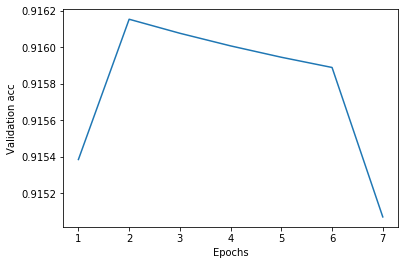

In [72]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_binary_accuracy_history = smooth_curve(average_binary_accuracy_history[1:])

plt.plot(range(1, len(smooth_binary_accuracy_history) + 1), smooth_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

Modell ausführen. !!!!!! wenn nötig, Zahl der epochs im fünften Satz korrigieren !!!!!

In [73]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(x_train, y_train,
          epochs = 2, batch_size = 1)
mess_mse_score, mess_binary_accuracy_score = model.evaluate(x_mess, y_mess)

Epoch 1/2
133/133 [==============================] - 1s 7ms/step - loss: 0.0991 - binary_accuracy: 0.9023
Epoch 2/2
234/234 [==============================] - 0s 888us/step


In [74]:
mess_binary_accuracy_score, mess_mse_score

(0.9615384615384616, 0.04370034008752555)

Voraussagen

In [75]:
predictions=model.predict(x_mess)
#for i in range(len(predictions)):
    #print(model.predict(x_mess))

In [76]:
print('Maximaler Wert:', max(max(model.predict(x_mess))))

Maximaler Wert: 0.9043566


Voraussgen in den aussortierten Datensätzen

In [77]:
mod_pred = model.predict(x_mess)
cutoff_value = 0.3
for i in range(len(y_mess)):
    if mod_pred[i,0]>cutoff_value:
        if ((i==0)|(mod_pred[i-1,0]>cutoff_value))|(mod_pred[i+0]>cutoff_value):
            #if df.index_string ==0:
                print (i+0,"-",
                  #i+2,"-", 
                  #y_test[i],"-", 
                  mod_pred[i],"-",
                  df.quelle[i+0],"-", 
                  df.episode[i+0],"-",
                  df.index_string[i+0],'\n')

24 - [0.31165603] - at tirol_48ff - verfluchter kerl schrie der baerenhansel was hast du gemacht wir haben hunger dass wir die sterne am hellichten tage sehen und freuten uns auf deine mahlzeit  und nun hast du uns so arg betrogen - 0 

25 - [0.43446517] - at tirol_48ff - der mueller schaemte sich die wahrheit zu sagen und sprach als ihr fort waret befiel mich ein solches grimmen dass ich mich wie ein wurm wand und nicht arbeiten konnte - 0 

26 - [0.6889901] - at tirol_48ff - sie stillten nun ihren hunger mit kalten speisen legten sich dann zur ruhe und schliefen die ganze nacht tief und fest wie murmeltiere am folgenden morgen zog der mueller mit dem baerenhansel auf die jagd und der kohlenbrenner musste im schlosse bleiben um das essen zu bereiten ihm ging es aber nicht besser als dem mueller denn es kamen wieder die geister aus dem kamin herab und pruegelten den koch derartig durch dass er wie tot niederfiel als die zwei jaeger nach hause kamen fanden sie kein mahl bestellt und der

Voraussage: gewünschte Datensetze abrufen

In [78]:
#for i in range(len(x_mess)):
    #if i>30:
        #print(i+0,"-",
              #model.predict(x_mess)[i],"-",
              #df.quelle[i+0],"-",
              #df.episode[i+0],"-",
              #df.index_string[i+0],'\n')